<a href="https://colab.research.google.com/github/sayalighodekar/ML-Climate-Final-Project-Template/blob/main/ml_climate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! unzip /content/sample_data/kaggle_water_bodies_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [4]:
import os
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [5]:
images_dir = './Water Bodies Dataset/Images'
masks_dir = './Water Bodies Dataset/Masks'

dirname, _, filenames = next(os.walk(images_dir))

In [6]:
@tf.function
def load_img_with_mask(image_path, images_dir : str = "Images", masks_dir : str = "Masks",
                       images_extension : str = "jpg", masks_extension: str = "jpg") -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    
    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels = 3, expand_animations = False)
    
    return (image, mask)

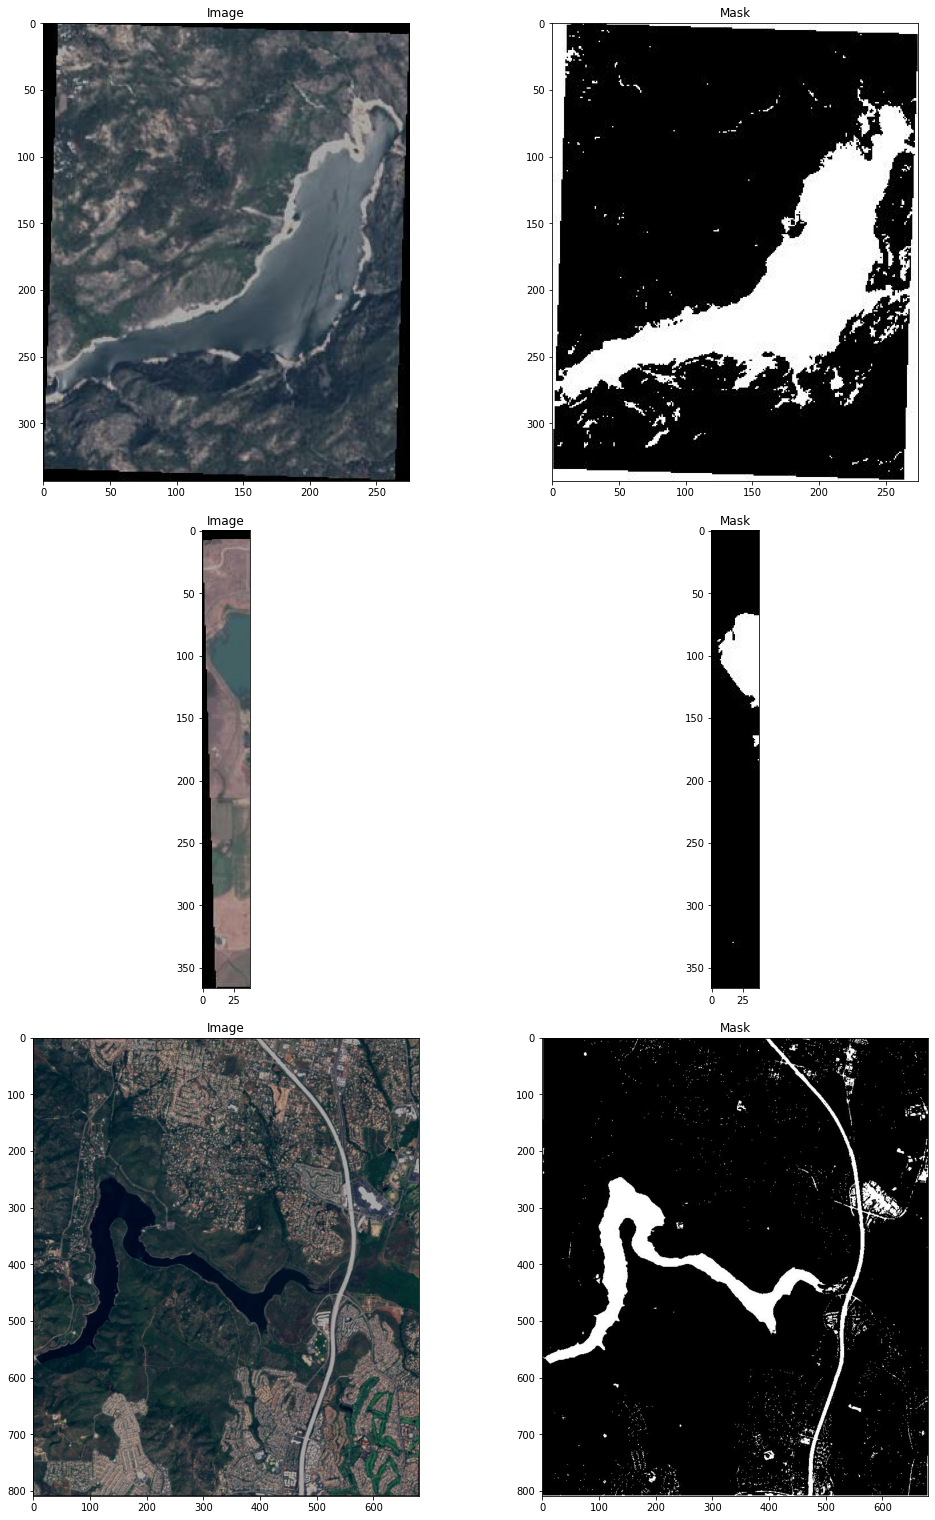

In [7]:
n = 3
examples = [load_img_with_mask(   os.path.join(images_dir, filenames[i]) ) for i in range(n)  ]

fig, axs = plt.subplots(n, 2, figsize = (14, 7*n), constrained_layout = True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")

In [8]:
@tf.function
def resize_images(images, masks):
    target_height, target_width = 128, 128
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

In [13]:
batch_size = 32
test_set_size = 300
validation_set_size =  250

dataset = tf.data.Dataset.list_files(images_dir+'/*.jpg', seed = 42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)

test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(resize_images)
test_dataset = test_dataset.batch(1).prefetch(5)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.batch(1).prefetch(5)

In [14]:
def conv_block(inputs, n_filters, max_Pooling = True):
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)
  
  if max_Pooling:
    down_output = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
  else:
    down_output = conv
  skip_output = conv

  return down_output, skip_output

In [15]:
def up_block(up_input, skip_input, n_filters):
  up = keras.layers.Conv2DTranspose(n_filters, kernel_size=3, strides = (2,2), padding = 'same')(up_input)
  sum = keras.layers.concatenate([up, skip_input], axis= 3)

  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(sum)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)

  return conv

In [16]:
def unet_model(input_size , n_filters, n_classes):
  inputs = keras.layers.Input(input_size)

  down_block_1 = conv_block(inputs, n_filters, max_Pooling=True)
  down_block_2 = conv_block(down_block_1[0], n_filters*2, max_Pooling=True)
  down_block_3 = conv_block(down_block_2[0], n_filters*4, max_Pooling=True)
  down_block_4 = conv_block(down_block_3[0], n_filters*8, max_Pooling=True)
  down_block_5 = conv_block(down_block_4[0], n_filters*16, max_Pooling=False)

  up_block_6 = up_block(down_block_5[0], down_block_4[1], n_filters*8)
  up_block_7 = up_block(up_block_6, down_block_3[1], n_filters*4)
  up_block_8 = up_block(up_block_7, down_block_2[1], n_filters*2)
  up_block_9 = up_block(up_block_8, down_block_1[1], n_filters)

  conv_9 = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(up_block_9)

  conv_10 = keras.layers.Conv2D(n_classes, kernel_size = 1, activation = 'sigmoid')(conv_9)

  model = keras.Model(inputs = inputs, outputs= conv_10)

  return model

In [17]:
model = unet_model(input_size=(128, 128, 3), n_filters= 32, n_classes= 3)

In [18]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [19]:
model.compile(optimizer = 'adam', 
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
epochs = 10
checkpoint_path = "/content/sample_data/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

In [22]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[cp_callback, early_stopping, lr_reduce])

Epoch 1/10
2291/2291 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.3716
Epoch 1: saving model to /content/sample_data/cp.ckpt
2291/2291 [==============================] - 145s 57ms/step - loss: 0.5135 - accuracy: 0.3716 - val_loss: 0.5450 - val_accuracy: 0.2924 - lr: 0.0010
Epoch 2/10
2290/2291 [============================>.] - ETA: 0s - loss: 0.4568 - accuracy: 0.3313
Epoch 2: saving model to /content/sample_data/cp.ckpt
2291/2291 [==============================] - 124s 54ms/step - loss: 0.4568 - accuracy: 0.3312 - val_loss: 0.4247 - val_accuracy: 0.2609 - lr: 0.0010
Epoch 3/10
2290/2291 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.2966
Epoch 3: saving model to /content/sample_data/cp.ckpt
2291/2291 [==============================] - 123s 53ms/step - loss: 0.4471 - accuracy: 0.2966 - val_loss: 0.3811 - val_accuracy: 0.3686 - lr: 0.0010
Epoch 4/10
2290/2291 [============================>.] - ETA: 0s - loss: 0.4124 - accuracy: 0.2650